Import library and dataset

In [ ]:
import git
import os

In [ ]:
git.Repo.clone_from(
    'https://github.com/grocerease-capstone/ml-data-scrapper.git',
    os.path.join('repo-scrapper'),
)

<git.repo.base.Repo '/content/repo-scrapper/.git'>

In [ ]:
import csv
import pandas as pd
import re

## Prepare the Dataset

load the dataset and clean them by lowering case the product name, delete the size of item, and deleting any useless character

In [ ]:
df = pd.read_csv(os.path.join('repo-scrapper', 'data', 'makanan.csv'))
labels = df.iloc[:, 0]

def clean_product_name(product_name: str):
  product_name = product_name.lower()
  product_name = re.sub(r'\b\d+(\.\d+)?x\d+(\.\d+)?(g|ml|kg|lt)\b', '', product_name)
  product_name = re.sub(r'\b\d+(\.\d+)?(g|ml|kg|lt)\b', '', product_name)
  product_name = re.sub(r'\b\d+(g|ml|kg|lt)\b', '', product_name)
  product_name = re.sub(r'\b\d+\'s\b', '', product_name)
  product_name = re.sub(r'[^a-z\s]', '', product_name)
  product_name = product_name.strip()

  return product_name

labels = labels.apply(clean_product_name)
labels = labels.unique()
print(f'len: {len(labels)}')
print(labels)

len: 863
['mrbread roti tawar tebal' 'fs beras ketan putih' 'indomaret pop corn'
 'indomaret crispy seaweed barbeque' 'indomaret crispy seaweed original'
 'indomaret bihun beras' 'indomaret keripik pisang candi'
 'indomaret mi goreng ala indonesia' 'indomaret mi goreng pedas'
 'tropicana slim diet jam strawbery' 'promina snack softcorn buttermilk'
 'samyang mie instant goreng pedas ayam  cup'
 'maya sardine in tomato sauce' 'pringles potato crisps cheesy cheese'
 'pringles potato crisps original'
 'pringles potato crisps sourcream  onion'
 'tao kae noi crispy seaweed hot  spicy'
 'tao kae noi crispy seaweed original' 'pringles potato crisps saucy bbq'
 'tao kae noi crispy seaweed big sheet classic'
 'tao kae noi crispy seaweed big sheet spicy' 'mujigae jajangmyeon'
 'heinz farleys biscuit original'
 'promina snack rice crackers broccoli  kale'
 'potabee snack potato chips melted cheese steak'
 'japota potato chips happy honey butter'
 'japota potato chips umami japanese seaweed'
 'miln

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 26.6 MB/s eta 0:00:00


Function to augmented the dataset so it will has different type of name product. This is will add more rows in the dataset.

In [ ]:
import nlpaug.augmenter.char as nac
import typing

In [ ]:
def augment_product_name(
    product_name: str,
    length: int,
) -> typing.List[str]:
  results: typing.List[str] = list[str]()

  # delete all vocal
  results.append(re.sub(r'[aiueo]', '', product_name))

  # delete all vocal per word
  # for word in product_name.split(' '):
  #   new_word = re.sub(r'[aiueo]', '', word)
  #   if len(new_word) > 1:
  #     results.append(new_word)

  # ocr
  aug = nac.OcrAug()
  augmented_texts = aug.augment(product_name, n=length)
  for augmented_text in augmented_texts:
    if not augmented_text in results:
      results.append(augmented_text)

  # random delete
  aug = nac.RandomCharAug(action='delete')
  augmented_texts = aug.augment(product_name, n=length)
  for augmented_text in augmented_texts:
    if not augmented_text in results:
      results.append(augmented_text)

  # random substitute
  aug = nac.RandomCharAug(action='substitute')
  augmented_texts = aug.augment(product_name, n=length)
  for augmented_text in augmented_texts:
    if not augmented_text in results:
      results.append(augmented_text)

  return results

In [ ]:
if not os.path.exists('data'):
  os.mkdir('data')

with open(os.path.join('data', 'augmented.csv'), mode='w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['text', 'label'])

  for label in labels:
    augmented_texts = augment_product_name(label, 10)
    for augmented_text in augmented_texts:
      writer.writerow([augmented_text, label])

Function to shuffle inside dataset

In [ ]:
def shuffle_csv(csv_filepath, output_csv_filename):
    output_filepath = os.path.join('data', output_csv_filename)

    data_frame = pd.read_csv(csv_filepath)
    data_frame = data_frame.sample(frac=1).reset_index(drop=True)
    data_frame.to_csv(output_filepath, index=False)

    return output_filepath

In [ ]:
shuffle_csv(
    os.path.join('data', 'augmented.csv'),
    'shuffled_augmented.csv',
)

'data/shuffled_augmented.csv'

In [ ]:
# df_aug = pd.read_csv(os.path.join('data', 'shuffled_augmented.csv'))

## Data separate, vectorizer, etc

seperate the data into train and validate data

In [ ]:
import tensorflow as tf

def train_val_datasets():
  df = pd.read_csv(os.path.join('data', 'shuffled_augmented.csv'))

  train_size = int(0.9 * len(df))

  train_texts = df.iloc[:train_size, 0]
  train_labels = df.iloc[:train_size, 1]

  val_texts = df.iloc[train_size:, 0]
  val_labels = df.iloc[train_size:, 1]

  train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
  val_dataset = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))

  return train_dataset, val_dataset

In [ ]:
train_dataset, validation_dataset = train_val_datasets()

print(f"There are {train_dataset.cardinality()} text-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} text-label pairs for validation.\n")

There are 22155 text-label pairs for training.

There are 2462 text-label pairs for validation.



In [ ]:
def standardize_text(text: str):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, r'[^a-z\s]', '')
  text = tf.strings.strip(text)

  return text

In [ ]:
test_product_name = 'Hello World 123#'
test_standardize_product_name = standardize_text(test_product_name)

print(f'product name: {test_product_name}')
print(f'standardized product name: \n{test_standardize_product_name}')

product name: Hello World 123#
standardized product name: 
b'hello world'


In [ ]:
def fit_vectorizer(product_names):
  vectorizer = tf.keras.layers.TextVectorization(
      standardize=standardize_text,
      # max_tokens=50000,
      output_sequence_length=8,
  )
  vectorizer.adapt(product_names)

  return vectorizer

In [ ]:
vectorizer = fit_vectorizer(train_dataset.map(lambda text, label: text))
vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 22647 words



In [ ]:
def fit_encoder():
  train_labels = train_dataset.map(lambda text, label: label)
  val_labels = validation_dataset.map(lambda text, label: label)
  labels  = train_labels.concatenate(val_labels)

  encoder = tf.keras.layers.StringLookup(
      num_oov_indices=1,
      oov_token='<unk>'
  )
  encoder.adapt(labels)

  return encoder

In [ ]:
encoder = fit_encoder()
print(f'unique labels len: {len(encoder.get_vocabulary())}')

unique labels len: 864


In [ ]:
def preprocess_dataset(dataset, vectorizer, encoder):
  dataset = dataset.map(lambda text, label: (vectorizer(text), encoder(label)))
  dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  dataset = dataset.batch(8)

  return dataset

In [ ]:
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, encoder)
val_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, encoder)

print(f'train dataset: {train_proc_dataset.cardinality()}\n')
print(f'val dataset: {val_proc_dataset.cardinality()}\n')

train dataset: 2770

val dataset: 308



In [ ]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
val_batch = next(val_proc_dataset.as_numpy_iterator())

print(f"shape train: {train_batch[0].shape}")
print(f"shape val: {val_batch[0].shape}")

shape train: (8, 8)
shape val: (8, 8)


## Create the model

In [ ]:
def create_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(100,)),
      tf.keras.layers.Embedding(
          input_dim=vocab_size+1,
          output_dim=128,
          mask_zero=True,
      ),
      # tf.keras.layers.LSTM(256, return_sequences=True, activation='relu'),
      tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3),
      tf.keras.layers.Dense(
          units=64,
          activation='relu',
      ),
      # tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(
          units=len(encoder.get_vocabulary()),
          activation='softmax',
      ),
  ])

  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizer,
      metrics=['accuracy'],
  )

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       2,898,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 864)                 │          56,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,094,944 (11.81 MB)

 Trainable params: 3,094,944 (11.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
example_batch = train_proc_dataset.take(1)

try:
  model.evaluate(example_batch)
except Exception as e:
  print(f'error: {e}')
else:
  print('no error')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - accuracy: 0.0000e+00 - loss: 6.7614
no error


In [ ]:
history = model.fit(
    train_proc_dataset,
    validation_data=val_proc_dataset,
    epochs=30,
)

Epoch 1/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 103s 36ms/step - accuracy: 0.0040 - loss: 6.7137 - val_accuracy: 0.0138 - val_loss: 6.0329
Epoch 2/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - accuracy: 0.0232 - loss: 5.7078 - val_accuracy: 0.1056 - val_loss: 4.6160
Epoch 3/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 97s 35ms/step - accuracy: 0.1339 - loss: 4.3360 - val_accuracy: 0.2965 - val_loss: 3.3181
Epoch 4/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 141s 35ms/step - accuracy: 0.3046 - loss: 3.1888 - val_accuracy: 0.4703 - val_loss: 2.4326
Epoch 5/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - accuracy: 0.4736 - loss: 2.3652 - val_accuracy: 0.5837 - val_loss: 1.8363
Epoch 6/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 0.5985 - loss: 1.7676 - val_accuracy: 0.6718 - val_loss: 1.4192
Epoch 7/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 140s 34ms/step - accuracy: 0.6985 - loss: 1.3341 - val_accuracy: 0.7031 - val_loss: 1.1533
Epoch 8/30
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 0.76

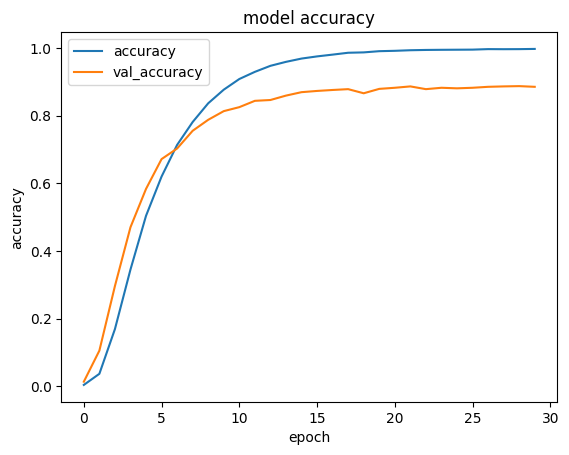

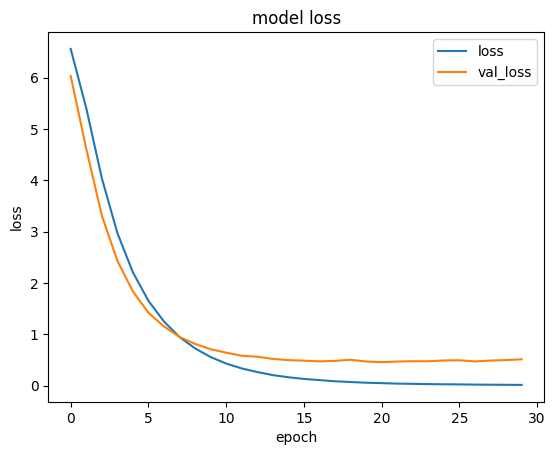

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.title(f'model {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend([metric, f'val_{metric}'])
  plt.show()

plot_graph('accuracy')
plot_graph('loss')

In [ ]:
import numpy as np

test the model

In [ ]:
test_text = 'mrie bskuit klpa'
standardized_text = standardize_text(test_text)
vectorized_text = vectorizer([standardized_text])

prediction = model.predict(vectorized_text)
# print(prediction)
# print(f'predicted label: {encoder.get_vocabulary()[np.argmax(prediction)]}')

# Mengambil tiga prediksi terbesar
top_3_indices = np.argsort(prediction[0])[-5:][::-1]  # Urutkan dari yang terbesar
top_3_predictions = [(encoder.get_vocabulary()[i], prediction[0][i]) for i in top_3_indices]

# Menampilkan hasil
print("Top 3 predictions:")
for label, prob in top_3_predictions:
    print(f"Label: {label}, Probability: {prob:.4f}")
    if prob > 0.8:
      print('-' * 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Top 3 predictions:
Label: roma biscuit kelapa, Probability: 0.8159
----------
Label: khong guan biscuit mini assorted, Probability: 0.0424
Label: khong guan biscuit red assorted, Probability: 0.0391
Label: mamasuka rumput laut panggang nori, Probability: 0.0151
Label: unibis biscuit coco puff, Probability: 0.0140
